# 🛢️ Problema

Você foi escalado como cientista de dados em uma grande empresa de petróleo e recebeu a missão de criar um **modelo preditivo** para estimar o **preço do petróleo em dólar**. Esse modelo será integrado a uma **aplicação interativa** desenvolvida com Streamlit, com o objetivo de auxiliar gestores na **tomada de decisões estratégicas** com base na variação do preço do petróleo.

📌 **Base de dados principal**:  

[Preço do petróleo bruto Brent (IPEADATA)](http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view)

**📦 Entregáveis**

- ✅ Link da aplicação com o modelo preditivo em Streamlit  
- ✅ Notebook Python contendo toda a pipeline de construção do modelo  
- ✅ Descrição do objetivo e abordagem adotada


**💡 Proposta**

Durante o desenvolvimento, percebeu-se que utilizar **apenas a série histórica do preço do petróleo** não seria suficiente para gerar um modelo robusto. Para enriquecer a análise, foram incorporados **dados complementares**, especialmente sobre a **produção mundial de petróleo**.

Além disso, estudos apontam que fatores **climáticos** — como o inverno em países do hemisfério norte — influenciam diretamente o consumo de petróleo, o que pode provocar variações significativas no preço.

Com base nesses dados, o modelo buscará prever o valor médio do barril de petróleo considerando:

- Volume de produção mundial (média diária de barris)  
- Estação do ano (como proxy para variações de consumo)  
- Tendências históricas

O objetivo principal é **identificar relações entre oferta (produção) e preço**, por exemplo:

- Quedas na produção podem causar aumento no preço?  
- Aumento na produção leva a redução de valor?

**🗃️ Bases de Dados Utilizadas**

- 📈 **Produção Mundial de Petróleo**: [EIA - U.S. Energy Information Administration](https://www.eia.gov).

- 💰 **Preço por Barril (Brent - FOB)**: [IPEADATA - Código EIA366_PBRENT366](http://www.ipeadata.gov.br).

# **Coleta de dados de produção de petróleo**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# URL da API
url = "https://api.eia.gov/v2/international/data/?api_key=UdhM1dqnrlS4xz52WPEndusafc88YhT0bXXiWC51&frequency=monthly&data[0]=value&facets[activityId][]=1&facets[productId][]=53&facets[countryRegionId][]=WORL&facets[unit][]=TBPD&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"

# Requisição
res = requests.get(url)

# Garantir que a resposta tenha a codificação UTF-8
res.encoding = 'utf-8'

# Converter a resposta JSON para dicionário
data = res.json()

# A parte dos dados está em data['response']['data']
base_producao = pd.DataFrame(data['response']['data'])

# Selecionando as colunas 'period' (data) e 'value' (valor)
base_producao = base_producao[['period', 'value']]

# Manter apenas ano e mês no formato 'YYYY-MM'
base_producao['period'] = pd.to_datetime(base_producao['period']).dt.to_period('M').astype(str)

# Opcional: definir 'period' como índice
base_producao.set_index('period', inplace=True)
base_producao.rename_axis('Data', inplace=True)

# Visualização
base_producao.head()


,value
Data,
2025-01,102548.47152680883107
2024-12,103350.864742429
2024-11,103415.016532477
2024-10,103198.880736693
2024-09,102060.489842431


# **Coleta de dados do valor do petróleo**

In [ ]:
import requests
import pandas as pd

# Código da série
codigo_serie = 'EIA366_PBRENT366'

# URL da API para obter os valores da série
url = f'http://www.ipeadata.gov.br/api/odata4/ValoresSerie(SERCODIGO=\'{codigo_serie}\')'

# Requisição GET para a API
response = requests.get(url)

# Verifique se a requisição foi bem-sucedida
if response.status_code == 200:
    # Converta a resposta JSON em um DataFrame
    data = response.json()
    base_valor = pd.DataFrame(data['value'])

    # Converter a coluna VALDATA para datetime (removendo fuso e mantendo apenas ano e mês)
    base_valor['VALDATA'] = pd.to_datetime(base_valor['VALDATA'], utc=True).dt.to_period('M').astype(str)
else:
    print(f'Erro ao acessar a API: {response.status_code}')

# Remover colunas desnecessárias
base_valor = base_valor.drop(columns=['SERCODIGO', 'NIVNOME', 'TERCODIGO'])

# Remover as datas duplicadas (mantendo a primeira ocorrência)
base_valor = base_valor.drop_duplicates(subset=['VALDATA'], keep='first')

# Definir a coluna VALDATA como índice e renomeá-la para "Ano-Mês"
base_valor = base_valor.set_index('VALDATA').rename_axis('Data')

# Remover valores ausentes
base_valor = base_valor.dropna()

# Visualização final
base_valor.head()


<ipython-input-92-8b8eada61034>:20: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  base_valor['VALDATA'] = pd.to_datetime(base_valor['VALDATA'], utc=True).dt.to_period('M').astype(str)


,VALVALOR
Data,
1987-06,18.65
1987-07,18.98
1987-09,18.43
1987-10,18.50
1987-12,17.65


# **Juntando as duas bases em apenas um dataframe**

In [ ]:
# Fazendo o merge pelas datas
df_unido = pd.merge(base_producao, base_valor, on='Data', how='inner')

In [ ]:
print(df_unido.columns)

Index(['value', 'VALVALOR'], dtype='object')


In [ ]:
df_unido = df_unido.rename(columns={'value': 'Producao', 'VALVALOR': 'valor'})

In [ ]:
df_unido.head()

,Producao,valor
Data,,
2025-01,102548.47152680883107,76.14
2024-12,103350.864742429,72.81
2024-11,103415.016532477,73.63
2024-10,103198.880736693,75.30
2024-09,102060.489842431,77.82


# **Criando uma coluna com a estação do ano.**

Conforme perquisa a temperatura influencia diretamente no uso do petroléo pois em alguns paises o combustivel é utilizado para aquecimento.

In [ ]:

# Função para obter a estação do ano
def obter_estacao(data_str):
    mes = int(data_str.split('-')[1])
    if mes in [12, 1, 2]:
        return 'Verão'
    elif mes in [3, 4, 5]:
        return 'Outono'
    elif mes in [6, 7, 8]:
        return 'Inverno'
    elif mes in [9, 10, 11]:
        return 'Primavera'

# Aplicar a função ao índice e criar a nova coluna
df_unido['Estacao'] = df_unido.index.map(obter_estacao)

In [ ]:
df_unido.head()

,Producao,valor,Estacao
Data,,,
2025-01,102548.47152680883107,76.14,Verão
2024-12,103350.864742429,72.81,Verão
2024-11,103415.016532477,73.63,Primavera
2024-10,103198.880736693,75.30,Primavera
2024-09,102060.489842431,77.82,Primavera


Visualização dos valores e primeiros estudos para o desenvolvimento do Machine Leaning.

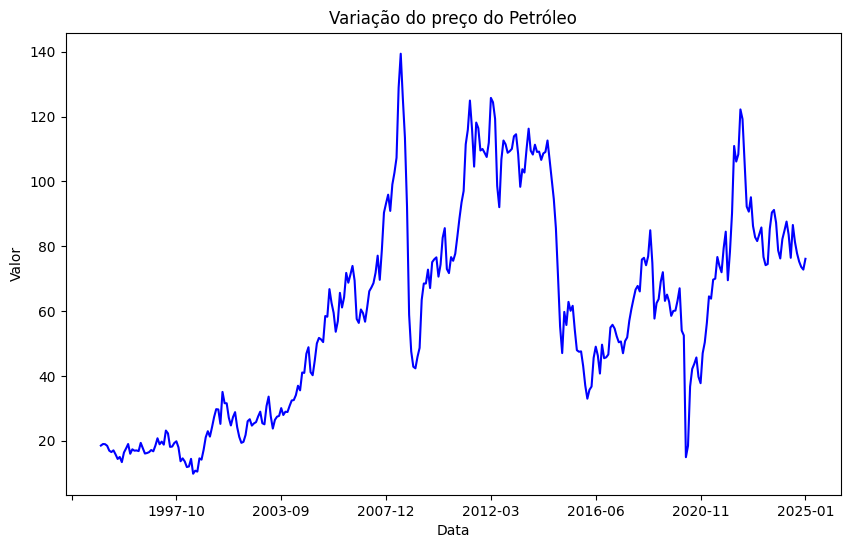

In [ ]:
import matplotlib.pyplot as plt

#Grafico de valor
df_unido['valor'].plot(figsize=(10, 6), linestyle='-', color='b')

#Adicionando rótulos e Titulo ao grafico
plt.title('Variação do preço do Petróleo')
plt.xlabel('Data')
plt.ylabel('Valor')

# Inverter a ordem dos anos (eixo X)
plt.gca().invert_xaxis()

#Exibindo o gráfico
plt.show()

In [ ]:
#Transformando a coluna produção em numero
df_unido['Producao'] = pd.to_numeric(df_unido['Producao'], errors='coerce')

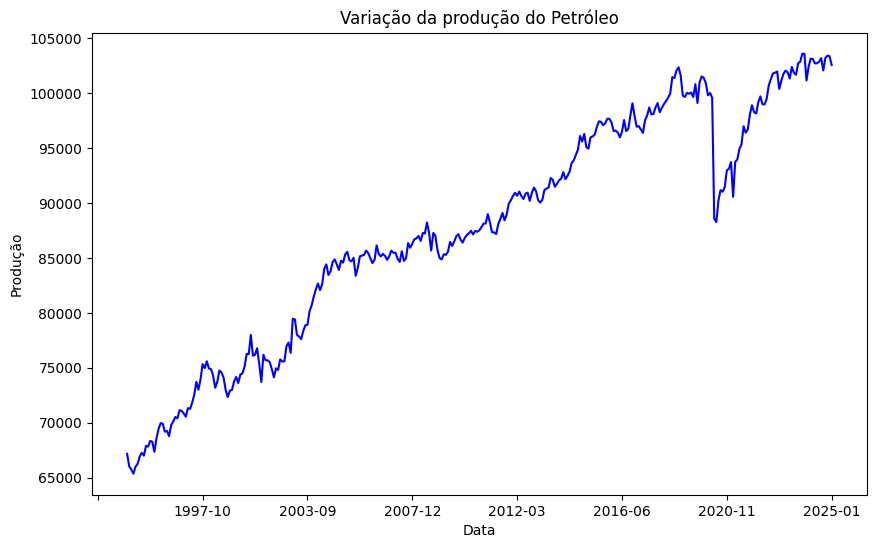

In [ ]:
# Garantir que 'Producao' é numérico
df_unido['Producao'] = pd.to_numeric(df_unido['Producao'], errors='coerce')

# Plot do gráfico
df_unido['Producao'].plot(figsize=(10, 6), linestyle='-', color='b')

# Adicionando rótulos e título
plt.title('Variação da produção do Petróleo')
plt.xlabel('Data')
plt.ylabel('Produção')

# Inverter a ordem dos anos (eixo X)
plt.gca().invert_xaxis()

# Exibir o gráfico
plt.show()


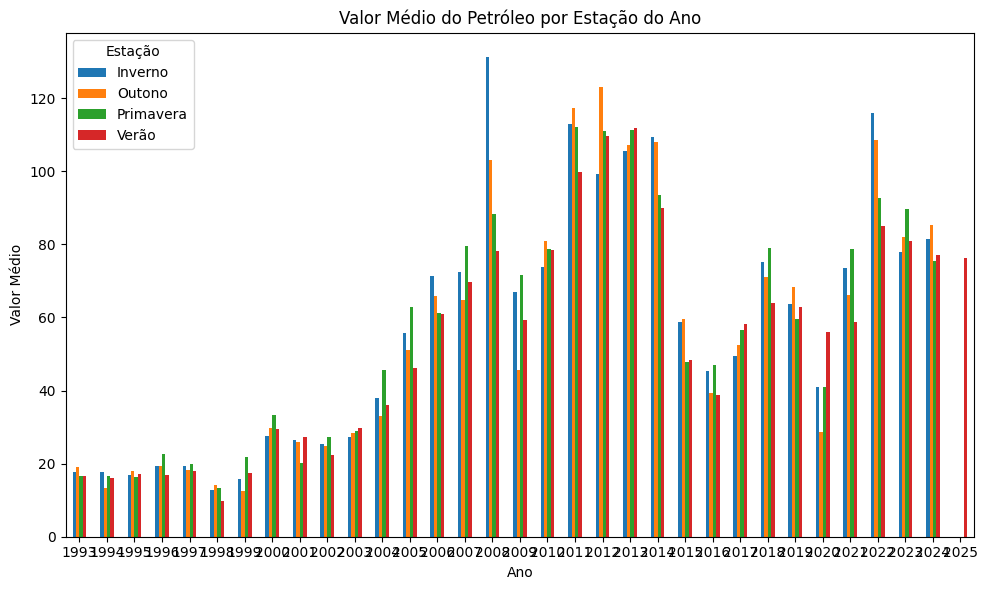

In [ ]:
# Dados por ano e estação, calculando a média do valor
media_valor_por_estacao = df_unido.groupby([pd.to_datetime(df_unido.index).year, 'Estacao'])['valor'].mean().unstack()

# Gráfico de barras agrupadas
media_valor_por_estacao.plot(kind='bar', figsize=(10, 6))

# Rótulos e título ao gráfico
plt.title('Valor Médio do Petróleo por Estação do Ano')
plt.xlabel('Ano')
plt.ylabel('Valor Médio')
plt.xticks(rotation=0)
plt.legend(title='Estação')

# Plotar
plt.tight_layout()
plt.show()


O gráfico apresenta a variação do valor médio do petróleo por estação do ano ao longo dos anos, de 1993 a 2025. Observa-se uma tendência geral de crescimento nos preços até por volta de 2008, com um pico expressivo nesse ano, seguido de uma queda brusca em 2009, o que pode estar associado à crise financeira global. Após esse período, os valores retomam o crescimento, atingindo novo patamar elevado entre 2011 e 2014, seguido por outra queda acentuada. A partir de 2020, o gráfico mostra uma nova oscilação significativa, provavelmente reflexo da pandemia de COVID-19 e instabilidades geopolíticas. Em relação às estações do ano, os valores tendem a ser similares, com pequenas variações entre elas, sugerindo que a sazonalidade tem influência limitada, embora o inverno e o outono frequentemente apresentem valores um pouco mais altos, possivelmente devido ao aumento da demanda por combustíveis para aquecimento em regiões temperadas.

# **Realizando a decomposição das serie temporal para um melhor entendimento em relação aos dados.**

In [ ]:
 conteudo = seasonal_decompose(df_unido['valor'], model='multiplicative', period=5)

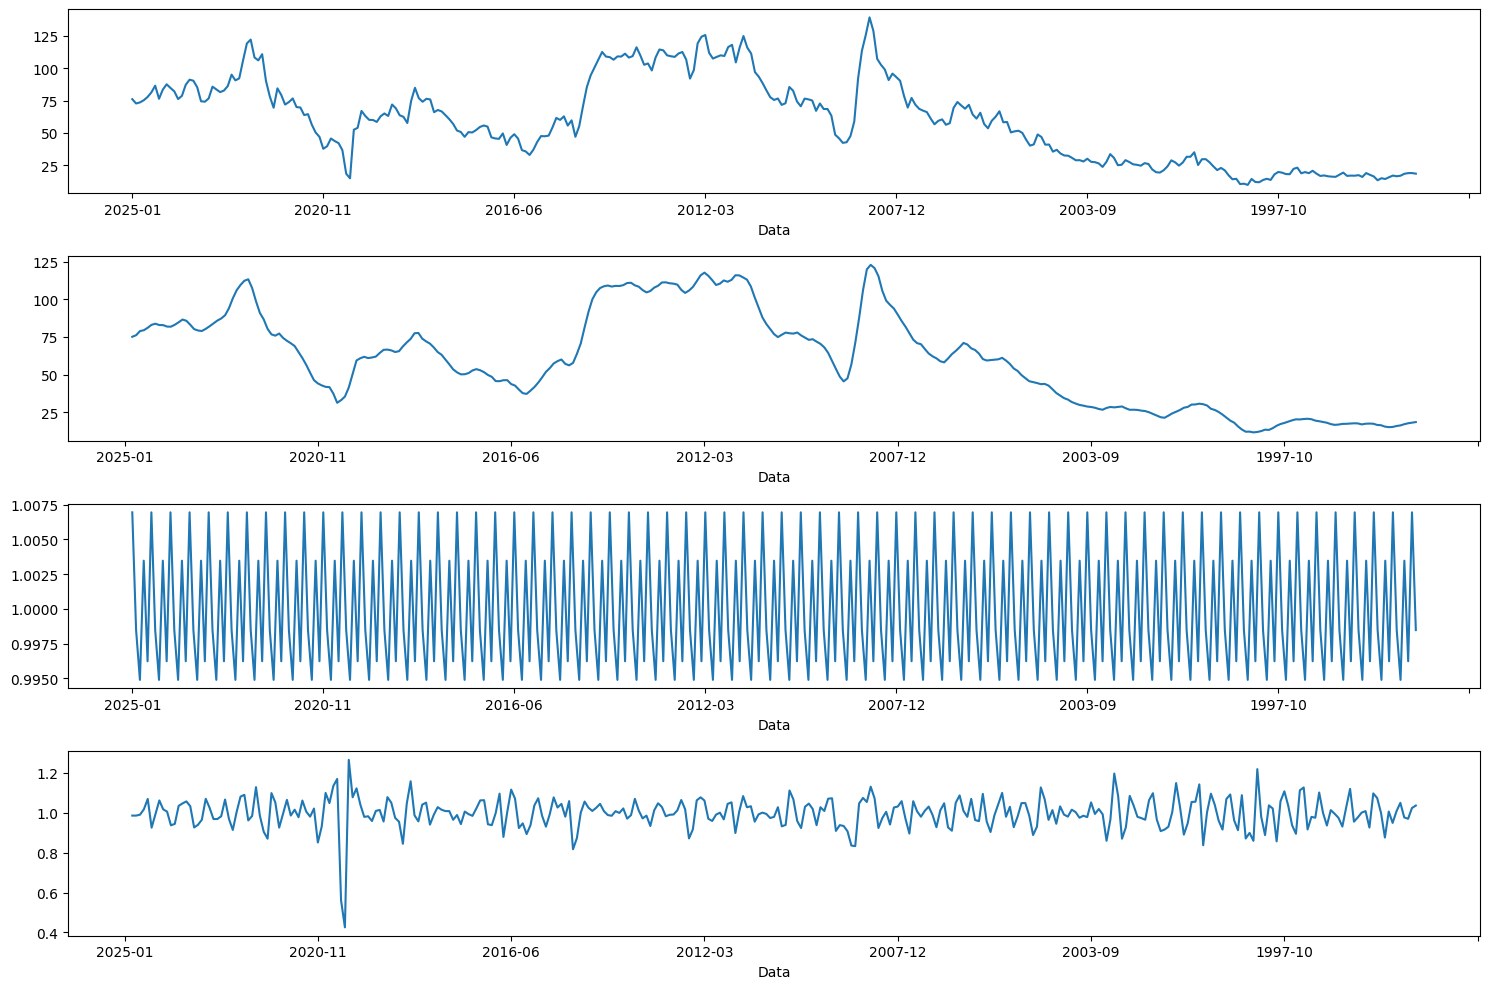

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))

conteudo.observed.plot(ax=ax1)  # Série dos dados
conteudo.trend.plot(ax=ax2)     # Tendência dos dados
conteudo.seasonal.plot(ax=ax3)  # Sazonalidade
conteudo.resid.plot(ax=ax4)     # Resíduos

plt.tight_layout()


# **Criando o modelo de machine Leaning para realizar a previsão do preço dos combustiveis.**

In [ ]:
!pip install ace_tools

              Real  Previsto
Data                        
2022-08-01  106.09   79.2223
2022-07-01  119.21   83.6591
2022-06-01  122.20   83.6591
2022-05-01  108.36   82.3270
2022-04-01  106.13   82.3270


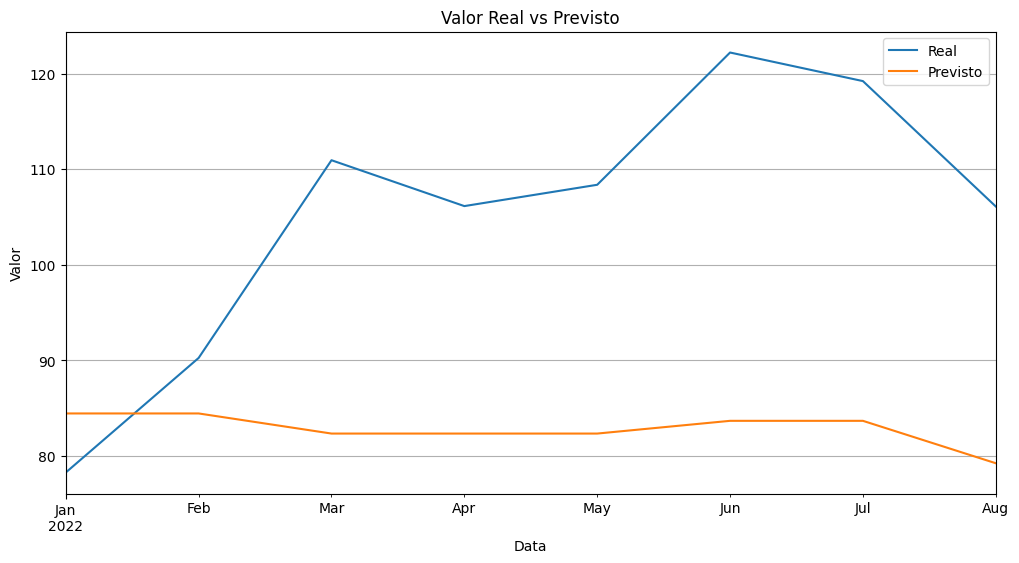

(-2.7878853192113406, 23.92356249999999, np.float64(26.470553779837125))

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

df_unido.index = pd.to_datetime(df_unido.index)

# Filtrando os últimos 3 anos de dados
df_filtrado = df_unido[df_unido.index >= (df_unido.index.max() - pd.DateOffset(years=3))]

# Codificando a variável categórica "Estacao"
df_filtrado = pd.get_dummies(df_filtrado, columns=["Estacao"], drop_first=True)

# Separando features e target
X = df_filtrado.drop(columns=["valor"])
y = df_filtrado["valor"]

# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Treinando o modelo
modelo = RandomForestRegressor(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

# Fazendo previsões
y_pred = modelo.predict(X_test)

# Avaliando o modelo
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Exibindo comparativo entre valores reais e previstos
df_resultado = pd.DataFrame({'Real': y_test.values, 'Previsto': y_pred}, index=y_test.index)
print(df_resultado.head())

# Opcional: visualizar graficamente
df_resultado.plot(figsize=(12, 6), title='Valor Real vs Previsto')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

r2, mae, rmse


# **Realizando previsões para os proximos 12 meses**

In [ ]:
#Indice de datas mensais para os próximos 12 meses
proximos_12_meses = pd.date_range(start=df_unido.index.max() + pd.DateOffset(months=1), periods=12, freq='MS')


In [ ]:
# Média da produção recente e estação por data
media_producao = df_filtrado['Producao'].mean()

def obter_estacao(mes):
    if mes in [12, 1, 2]:
        return 'Verão'
    elif mes in [3, 4, 5]:
        return 'Outono'
    elif mes in [6, 7, 8]:
        return 'Inverno'
    else:
        return 'Primavera'

df_futuro = pd.DataFrame(index=proximos_12_meses)
df_futuro['Producao'] = media_producao  # ou outro valor estimado
df_futuro['Estacao'] = df_futuro.index.month.map(obter_estacao)


In [ ]:
df_futuro = pd.get_dummies(df_futuro, columns=["Estacao"], drop_first=True)

# Garantir que todas as colunas estão presentes (igual ao treino)
for col in X_train.columns:
    if col not in df_futuro.columns:
        df_futuro[col] = 0

# Reordenar colunas
df_futuro = df_futuro[X_train.columns]


            Valor_Previsto
Data                      
2025-02-01         80.4773
2025-03-01         82.3073
2025-04-01         82.3073
2025-05-01         82.3073
2025-06-01         80.0224
2025-07-01         80.0224
2025-08-01         80.0224
2025-09-01         91.1007
2025-10-01         91.1007
2025-11-01         91.1007
2025-12-01         80.4773
2026-01-01         80.4773


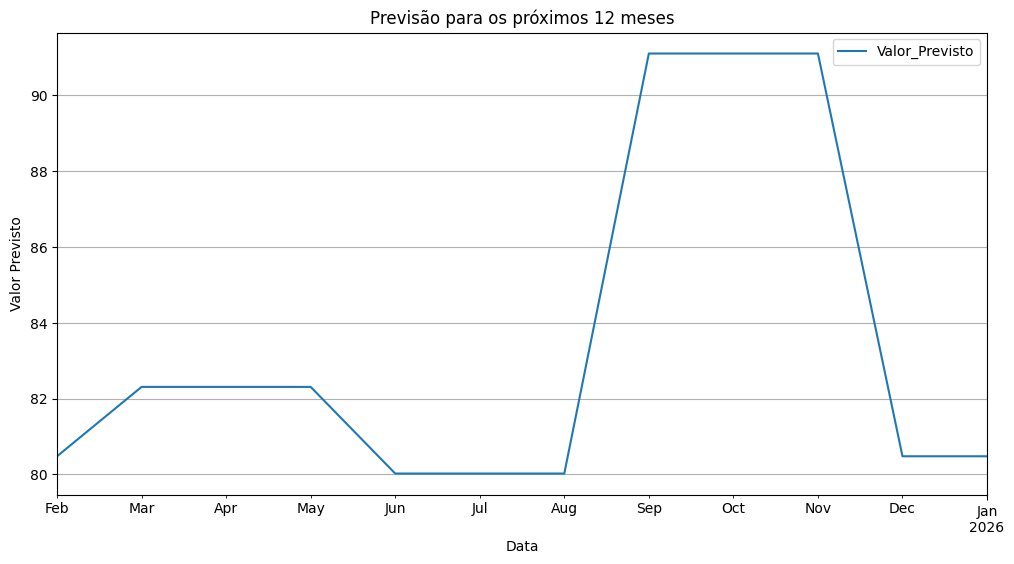

In [ ]:
previsao_futura = modelo.predict(df_futuro)

# Resultado com datas
df_previsao = pd.DataFrame({'Data': df_futuro.index, 'Valor_Previsto': previsao_futura}).set_index('Data')
print(df_previsao)

# Plotar
df_previsao.plot(title='Previsão para os próximos 12 meses', figsize=(12,6))
plt.xlabel('Data')
plt.ylabel('Valor Previsto')
plt.grid(True)
plt.show()


# **Extraindo o modelo:**

In [ ]:
import joblib

# Salvar o modelo em um arquivo
joblib.dump(modelo, 'modelo_random_forest.pkl')


['modelo_random_forest.pkl']